In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import SimpleITK as sitk

from typing import List, Tuple
import torch
import hydra
import omegaconf
import numpy as np
from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger
from src.models.UNet3D import BasicUNet3D
from torchmetrics import Dice
# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('medium')

from dotenv import load_dotenv

load_dotenv(Path.cwd().parent/'.env')


True

In [4]:
log = utils.get_pylogger(__name__)
# realtive patj
EVAL_PATH = '../logs/leftsulci65-maskeddice-rotate-replicationtest/runs/2023-02-27_14-47-42/.hydra'

# abs path
CHKPT_PATH = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs/leftsulci65-maskeddice-rotate-replicationtest/runs/2023-02-27_14-47-42/checkpoints/epoch-078.ckpt'

device = 'cuda:0'

cfg = omegaconf.OmegaConf.load(EVAL_PATH + '/config.yaml')

In [5]:
cfg.ckpt_path = CHKPT_PATH
cfg.test = True

In [6]:
cfg.ckpt_path = CHKPT_PATH

# cfg.data.validation_batch_size = 2
# cfg.data.dataset_cfg.padd2same_size = True 

log.info(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

log.info(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model).to(device)

log.info(f"Instantiating trainer <{cfg.trainer._target_}>")
trainer: Trainer = Trainer(gpus=1, max_epochs=1, logger=False)

2023-02-27 15:34:56,529 - Instantiating datamodule <src.data.bvisa_dm.CS_DataModule>
2023-02-27 15:34:56,550 - Len of train examples 38 len of validation examples 12
2023-02-27 15:34:56,551 - Instantiating model <src.models.UNet3D.BasicUNet3D>
2023-02-27 15:34:57,369 - Instantiating trainer <pytorch_lightning.Trainer>


Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.test(model, dataloaders=datamodule.val_dataloader(),
             ckpt_path=CHKPT_PATH)

Restoring states from the checkpoint path at /mrhome/vladyslavz/git/central-sulcus-analysis/logs/leftsulci65-maskeddice-rotate-replicationtest/runs/2023-02-27_14-47-42/checkpoints/epoch-078.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /mrhome/vladyslavz/git/central-sulcus-analysis/logs/leftsulci65-maskeddice-rotate-replicationtest/runs/2023-02-27_14-47-42/checkpoints/epoch-078.ckpt
The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

No mask value specified for the MaskedLoss.
You called `self.log('test/Esubj', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/Esubj_epoch      │    0.2994106113910675     │
│         test/dsc          │    0.5497695207595825     │
│         test/loss         │    0.4384179413318634     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.4384179413318634,
  'test/dsc': 0.5497695207595825,
  'test/Esubj_epoch': 0.2994106113910675}]

In [8]:
for batch in datamodule.val_dataloader():
    image = batch['image']
    target = batch['target']
    break

model = model.to(device)
# make prediction

with torch.no_grad():
    pred_proba = model(image.to(device))

In [12]:
disc(torch.unsqueeze(pred, dim=0), target.to(device))

tensor(0.5362, device='cuda:0')

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.5362, device='cuda:0')

In [23]:
type(disc_score.as_tensor())

torch.Tensor

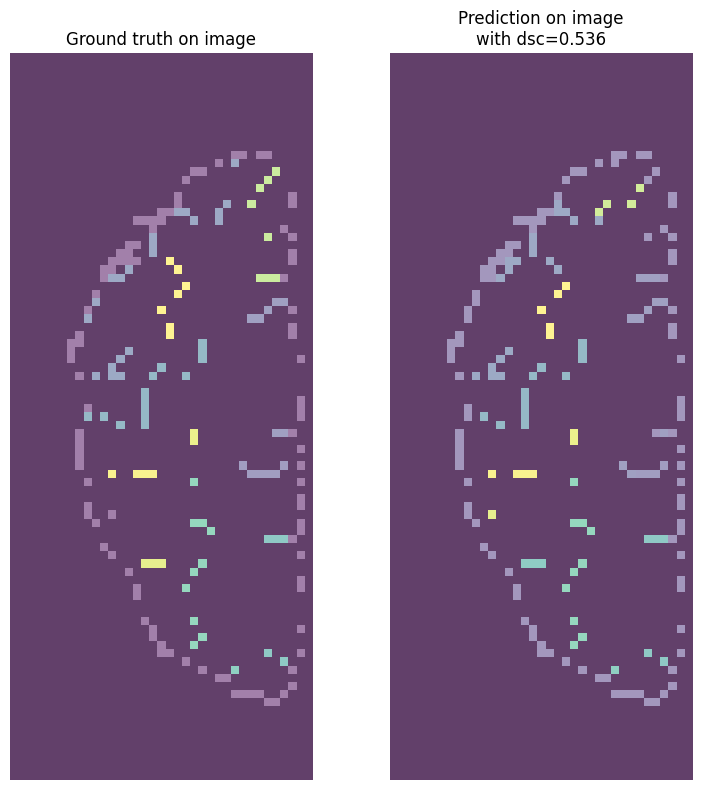

In [24]:
pred = torch.argmax((pred_proba[0, :, : :, :]), dim=0).to(device)

# set background to 0
pred[image[0,0,:,:,:] == 0] = 0

disc = Dice(ignore_index=0,
            average='macro',
            num_classes=65).to(device)

disc_score = disc(torch.unsqueeze(pred, dim=0), target.to(device)).as_tensor()


sliecnum = 50

fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(image[0, 0, sliecnum, :, :], cmap='gray', alpha=0.5)
ax[0].imshow(target[0, sliecnum, :, :], alpha=0.5)
ax[0].set_axis_off()
ax[0].set_title('Ground truth on image')

ax[1].imshow(image[0, 0, sliecnum, :, :], cmap='gray', alpha=0.5)
ax[1].imshow(pred[sliecnum, :, :].cpu().numpy(), alpha=0.5)
ax[1].set_axis_off()
ax[1].set_title(f'Prediction on image\nwith dsc={disc_score:.3f}')

plt.tight_layout()
plt.show()